In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_unweighted
import seaborn
%pylab inline
pd.set_option('display.max_rows', 150)

Populating the interactive namespace from numpy and matplotlib


In [2]:
vep_cols = """\
Allele|Annotation|Impact|Gene_name|Gene_id|Feature_type|Feature_id|Biotype|EXON\
|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids\
|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|CANONICAL\
|CCDS|HGVS_OFFSET\
"""
vep_cols = vep_cols.split("|")
vep_cols = [term.strip().capitalize() for term in vep_cols]

# Import Data

First we'll import the vcf files into Pandas dataframes. We split out the **ANN** INFO field and parse it into the component fields. Since an annotation is provided for each transcript, we split by transcript (ie splitting on `,`). Then for each transcript we break it into the fields specified by the tools documentation (splitting on `|`). Finally, we join back to the original dataframe, with each row representing a unique `POS`, `REF`, `ALT`, `Feature_id` combination.

In [3]:
vep_df = pd.read_table('./cftr.grch37.vep.vcf', header=0, skiprows=6, usecols=range(10))
info_df = vep_df["INFO"].str.replace("ANN=", "").str.split(",").apply(pd.Series, 1).stack()
info_df = info_df.str.split("|").apply(pd.Series, 1)
info_df.index = info_df.index.droplevel(-1)
info_df.columns = vep_cols
vep_df = vep_df.join(info_df)
vep_df = vep_df[['POS', 'REF', 'ALT', 'Feature_id', 'Biotype', 'Annotation', 'Impact', 'Hgvsc']]
del info_df
vep_df.head()

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc
0,117105737,C,A,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,
1,117105737,C,G,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,
2,117105737,C,T,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,
3,117105737,C,CA,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,
4,117105737,C,CG,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,


In [4]:
snpeff_cols = """\
Allele|Annotation|Impact|Gene_name|Gene_ID|Feature_type|Feature_ID|Biotype|Rank|HGVSc|HGVSp\
|cDNA_position|CDS_position|Protein_position|Distance|Errors"""
snpeff_cols = snpeff_cols.split("|")
snpeff_cols = [term.strip().capitalize() for term in snpeff_cols]

In [5]:
snpeff_df = pd.read_table('./cftr.grch37.snpeff.vcf', header=0, skiprows=9, usecols=range(10))
info_df = snpeff_df["INFO"].str.split(";").apply(pd.Series, 1)[0] #snpeff includes two other INFO fields that we don't need
info_df = info_df.str.replace("ANN=", "").str.split(",").apply(pd.Series, 1).stack()
info_df = info_df.str.split("|").apply(pd.Series, 1)
info_df.index = info_df.index.droplevel(-1)
info_df.columns = snpeff_cols
snpeff_df = snpeff_df.join(info_df)
snpeff_df = snpeff_df[['POS', 'REF', 'ALT', 'Feature_id', 'Biotype', 'Annotation', 'Impact', 'Hgvsc']]
del info_df
snpeff_df.head()

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc
0,117105737,C,A,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,n.-101C>A
0,117105737,C,A,ENSG00000214684-ENSG00000001626,,intergenic_region,MODIFIER,n.117105737C>A
1,117105737,C,G,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,n.-101C>G
1,117105737,C,G,ENSG00000214684-ENSG00000001626,,intergenic_region,MODIFIER,n.117105737C>G
2,117105737,C,T,ENST00000546407,processed_transcript,upstream_gene_variant,MODIFIER,n.-101C>T


# Collapsing Annotations

For each transcript-variant pair, the tool may provide multiple annotations. We'll only compare the most damaging as defined by the ranking in the ANN field spec.

In [6]:
#From http://snpeff.sourceforge.net/VCFannotationformat_v1.0.pdf with additions:
#VEP: non_coding_transcript_exon_variant, non_coding_transcript_variant, protein altering variant, 
#incomplete_terminal_codon_variant, NMD_transcript_variant
#Snpeff: conservative_inframe_deletion, conservative_inframe_insertion, structural_interaction_variant, 5_prime_UTR_truncation

ranked_terms = ["chromosome_number_variation","exon_loss_variant","frameshift_variant","stop_gained","stop_lost",
                "start_lost","splice_acceptor_variant","splice_donor_variant","rare_amino_acid_variant","missense_variant",
                "inframe_insertion","conservative_inframe_insertion", "disruptive_inframe_insertion","inframe_deletion","conservative_inframe_deletion", "disruptive_inframe_deletion",
                "5_prime_UTR_truncation+exon_loss_variant","5_prime_UTR_truncation","3_prime_UTR_truncation+exon_loss","splice_branch_variant",
                "splice_region_variant","stop_retained_variant","initiator_codon_variant",
                "synonymous_variant","initiator_codon_variant+non_canonical_start_codon","stop_retained_variant",
                "5_prime_UTR_variant","3_prime_UTR_variant","5_prime_UTR_premature_start_codon_gain_variant",
                "structural_interaction_variant", "protein_altering_variant","upstream_gene_variant","downstream_gene_variant",
                "TF_binding_site_variant","regulatory_region_variant","miRNA","custom","sequence_feature",
                "conserved_intron_variant","intron_variant","intragenic_variant","conserved_intergenic_variant",
                "intergenic_region", "coding_sequence_variant", "non_coding_exon_variant","non_coding_transcript_exon_variant",
                "nc_transcript_variant","non_coding_transcript_variant","NMD_transcript_variant", "incomplete_terminal_codon_variant", "gene_variant","chromosome"]
def term_rank(term):
    return ranked_terms.index(term)

In [7]:
vep_df["Effect"] = vep_df.apply(lambda row: min(row["Annotation"].split("&"), key=term_rank), axis=1)
snpeff_df["Effect"] = snpeff_df.apply(lambda row: min(row["Annotation"].split('&'), key=term_rank), axis=1)

In [8]:
vc_vep = vep_df.groupby(['Effect']).size()
vc_vep.name = "VEP"
vc_snpeff = snpeff_df.groupby(['Effect']).size()
vc_snpeff.name = "SnpEff"
vc_df = pd.DataFrame([vc_vep, vc_snpeff])
print("Annotations\n")
print(vc_df.transpose().fillna(0))
impact_vep = vep_df.groupby(['Impact']).size()
impact_vep.name = "VEP"
impact_snpeff = snpeff_df.groupby(['Impact']).size()
impact_snpeff.name = "SnpEff"
impact_df = pd.DataFrame([impact_vep, impact_snpeff])
print("\nImpacts")
print(impact_df.transpose())
counts_vep = vep_df.count()
counts_vep.name = 'VEP'
counts_snpeff = snpeff_df.count()
counts_snpeff.name = 'SnpEff'
counts_df = pd.DataFrame([counts_vep, counts_snpeff])
print("\nCounts")
print(counts_df.transpose())

Annotations

                                                     VEP    SnpEff
3_prime_UTR_variant                               6654.0    6680.0
5_prime_UTR_premature_start_codon_gain_variant       0.0     286.0
5_prime_UTR_variant                               9987.0   10259.0
coding_sequence_variant                             28.0       0.0
conservative_inframe_deletion                        0.0    4619.0
conservative_inframe_insertion                       0.0    8650.0
disruptive_inframe_deletion                          0.0    8990.0
disruptive_inframe_insertion                         0.0   17211.0
downstream_gene_variant                          99177.0   99185.0
exon_loss_variant                                    0.0       7.0
frameshift_variant                              113706.0  113693.0
incomplete_terminal_codon_variant                    8.0       0.0
inframe_deletion                                 13604.0       0.0
inframe_insertion                                

This example is interesting. Vep is usually a pretty general `protein_altering_variant` annotation. Snpeff breaks it down to `disruptive_inframe_insertion`.

In [9]:
vep_df[vep_df['Effect'].str.contains('protein_altering_variant')][:1]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19511,117120152,C,CCGA,ENST00000003084,protein_coding,protein_altering_variant,MODERATE,ENST00000003084.6:c.4_5insCGA,protein_altering_variant


In [10]:
vep_df.ix[19511]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19511,117120152,C,CCGA,ENST00000003084,protein_coding,protein_altering_variant,MODERATE,ENST00000003084.6:c.4_5insCGA,protein_altering_variant
19511,117120152,C,CCGA,ENST00000426809,protein_coding,protein_altering_variant,MODERATE,ENST00000426809.1:c.4_5insCGA,protein_altering_variant
19511,117120152,C,CCGA,ENST00000446805,protein_coding,intron_variant,MODIFIER,ENST00000446805.1:c.-191+404_-191+405insCGA,intron_variant
19511,117120152,C,CCGA,ENST00000454343,protein_coding,protein_altering_variant,MODERATE,ENST00000454343.1:c.4_5insCGA,protein_altering_variant
19511,117120152,C,CCGA,ENST00000546407,processed_transcript,intron_variant&non_coding_transcript_variant,MODIFIER,ENST00000546407.1:n.166+4290_166+4291insCGA,intron_variant


In [11]:
snpeff_df.ix[19511]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19511,117120152,C,CCGA,ENST00000003084,protein_coding,disruptive_inframe_insertion,MODERATE,c.4_5insCGA,disruptive_inframe_insertion
19511,117120152,C,CCGA,ENST00000454343,protein_coding,disruptive_inframe_insertion,MODERATE,c.4_5insCGA,disruptive_inframe_insertion
19511,117120152,C,CCGA,ENST00000426809,protein_coding,disruptive_inframe_insertion,MODERATE,c.4_5insCGA,disruptive_inframe_insertion
19511,117120152,C,CCGA,ENST00000546407,processed_transcript,intron_variant,MODIFIER,n.166+4290_166+4291insCGA,intron_variant
19511,117120152,C,CCGA,ENST00000446805,protein_coding,intron_variant,MODIFIER,c.-191+404_-191+405insCGA,intron_variant


So this example is interesting. It shows two things:
1. SnpEff is providing these "structural_interaction_variant" annotations, which vep does not provide
2. SnpEff is a bit more granular annotating inframe variants

In [12]:
snpeff_df[snpeff_df['Effect'].str.contains('structural_interaction_variant')][:1]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
58085,117182112,TTAA,T,2PZG:B_388-B_567:ENST00000003084,protein_coding,structural_interaction_variant,HIGH,c.1160_1162delTAA,structural_interaction_variant


In [13]:
vep_df.ix[58085]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
58085,117182112,TTAA,T,ENST00000003084,protein_coding,inframe_deletion,MODERATE,ENST00000003084.6:c.1160_1162delTAA,inframe_deletion
58085,117182112,TTAA,T,ENST00000426809,protein_coding,inframe_deletion,MODERATE,ENST00000426809.1:c.1070_1072delTAA,inframe_deletion
58085,117182112,TTAA,T,ENST00000454343,protein_coding,inframe_deletion,MODERATE,ENST00000454343.1:c.1160_1162delTAA,inframe_deletion


In [14]:
snpeff_df.ix[58085]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
58085,117182112,TTAA,T,2PZG:B_388-B_567:ENST00000003084,protein_coding,structural_interaction_variant,HIGH,c.1160_1162delTAA,structural_interaction_variant
58085,117182112,TTAA,T,ENST00000003084,protein_coding,disruptive_inframe_deletion,MODERATE,c.1160_1162delTAA,disruptive_inframe_deletion
58085,117182112,TTAA,T,ENST00000454343,protein_coding,disruptive_inframe_deletion,MODERATE,c.1160_1162delTAA,disruptive_inframe_deletion
58085,117182112,TTAA,T,ENST00000426809,protein_coding,disruptive_inframe_deletion,MODERATE,c.1070_1072delTAA,disruptive_inframe_deletion


Similarly to the structural interaction variant example, Snpeff provides an additional annotation called `sequence_feature`

In [15]:
snpeff_df[snpeff_df['Effect'].str.contains('sequence_feature')][3:4]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19449,117120148,C,CA,ENST00000003084,protein_coding,sequence_feature,LOW,c.-1_1insA,sequence_feature


In [16]:
vep_df.ix[19449]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19449,117120148,C,CA,ENST00000003084,protein_coding,5_prime_UTR_variant,MODIFIER,ENST00000003084.6:c.1dupA,5_prime_UTR_variant
19449,117120148,C,CA,ENST00000426809,protein_coding,upstream_gene_variant,MODIFIER,,upstream_gene_variant
19449,117120148,C,CA,ENST00000446805,protein_coding,intron_variant,MODIFIER,ENST00000446805.1:c.-191+401dupA,intron_variant
19449,117120148,C,CA,ENST00000454343,protein_coding,5_prime_UTR_variant,MODIFIER,ENST00000454343.1:c.1dupA,5_prime_UTR_variant
19449,117120148,C,CA,ENST00000546407,processed_transcript,intron_variant&non_coding_transcript_variant,MODIFIER,ENST00000546407.1:n.166+4287dupA,intron_variant


In [17]:
snpeff_df.ix[19449]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
19449,117120148,C,CA,ENST00000003084,protein_coding,frameshift_variant&start_lost,HIGH,c.1dupA,frameshift_variant
19449,117120148,C,CA,ENST00000454343,protein_coding,frameshift_variant&start_lost,HIGH,c.1dupA,frameshift_variant
19449,117120148,C,CA,ENST00000426809,protein_coding,frameshift_variant&start_lost,HIGH,c.1dupA,frameshift_variant
19449,117120148,C,CA,ENST00000003084,protein_coding,sequence_feature,LOW,c.-1_1insA,sequence_feature
19449,117120148,C,CA,ENST00000546407,processed_transcript,intron_variant,MODIFIER,n.166+4287dupA,intron_variant
19449,117120148,C,CA,ENST00000446805,protein_coding,intron_variant,MODIFIER,c.-191+401dupA,intron_variant


Here's a consequential mismatch. Vep annotates this deletion of a T on ENST00000446805 as `coding_sequence_variant` with a `LOW` impact, whereas SnpEff annotates it as a frameshift with a `HIGH` impact.

In [18]:
vep_df[vep_df['Effect'].str.contains('coding_sequence_variant')][:4]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
32771,117171030,CT,C,ENST00000446805,protein_coding,incomplete_terminal_codon_variant&coding_seque...,LOW,ENST00000446805.1:c.109delT,coding_sequence_variant
32774,117171031,T,A,ENST00000446805,protein_coding,incomplete_terminal_codon_variant&coding_seque...,LOW,ENST00000446805.1:c.109T>A,coding_sequence_variant
32775,117171031,T,G,ENST00000446805,protein_coding,incomplete_terminal_codon_variant&coding_seque...,LOW,ENST00000446805.1:c.109T>G,coding_sequence_variant
32776,117171031,T,C,ENST00000446805,protein_coding,incomplete_terminal_codon_variant&coding_seque...,LOW,ENST00000446805.1:c.109T>C,coding_sequence_variant


In [19]:
vep_df.ix[32771]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
32771,117171030,CT,C,ENST00000003084,protein_coding,frameshift_variant,HIGH,ENST00000003084.6:c.352delT,frameshift_variant
32771,117171030,CT,C,ENST00000426809,protein_coding,frameshift_variant,HIGH,ENST00000426809.1:c.352delT,frameshift_variant
32771,117171030,CT,C,ENST00000446805,protein_coding,incomplete_terminal_codon_variant&coding_seque...,LOW,ENST00000446805.1:c.109delT,coding_sequence_variant
32771,117171030,CT,C,ENST00000454343,protein_coding,frameshift_variant,HIGH,ENST00000454343.1:c.352delT,frameshift_variant


In [20]:
snpeff_df.ix[32771]

,POS,REF,ALT,Feature_id,Biotype,Annotation,Impact,Hgvsc,Effect
32771,117171030,CT,C,ENST00000003084,protein_coding,frameshift_variant,HIGH,c.352delT,frameshift_variant
32771,117171030,CT,C,ENST00000446805,protein_coding,frameshift_variant&splice_region_variant,HIGH,c.109delT,frameshift_variant
32771,117171030,CT,C,ENST00000454343,protein_coding,frameshift_variant,HIGH,c.352delT,frameshift_variant
32771,117171030,CT,C,ENST00000426809,protein_coding,frameshift_variant,HIGH,c.352delT,frameshift_variant
32771,117171030,CT,C,ENST00000003084,protein_coding,sequence_feature,LOW,c.352delT,sequence_feature


So we'll remove some of this inconsistances by dropping rows that are annotated as `structural_interaction_variant` or `sequence_feature` by Snpeff and normalizing SnpEff more granular *inframe* annotations.

In [21]:
snpeff_df = snpeff_df[~snpeff_df['Effect'].str.contains('structural_interaction_variant|sequence_feature')]

In [22]:
collapse_map = {
'3_prime_UTR_variant': '3_prime_UTR_variant', 
'5_prime_UTR_premature_start_codon_gain_variant': '5_prime_UTR_premature_start_codon_gain_variant',
'5_prime_UTR_variant': '5_prime_UTR_variant',
'coding_sequence_variant': 'coding_sequence_variant',
'conservative_inframe_deletion': 'inframe_deletion',
'conservative_inframe_insertion': 'inframe_insertion',
'disruptive_inframe_deletion': 'inframe_deletion',
'disruptive_inframe_insertion': 'inframe_insertion',
'downstream_gene_variant': 'downstream_gene_variant',
'exon_loss_variant': 'exon_loss_variant',
'frameshift_variant': 'frameshift_variant',
'incomplete_terminal_codon_variant': 'incomplete_terminal_codon_variant',
'inframe_deletion': 'inframe_deletion',
'inframe_insertion': 'inframe_insertion', 
'initiator_codon_variant': 'initiator_codon_variant',
'intergenic_region': 'intergenic_region',
'intron_variant': 'intron_variant',
'missense_variant': 'missense_variant',
'non_coding_transcript_exon_variant': 'non_coding_transcript_exon_variant',
'non_coding_transcript_variant': 'non_coding_transcript_variant',
'protein_altering_variant': 'inframe_insertion',
'splice_acceptor_variant': 'splice_acceptor_variant',
'splice_donor_variant': 'splice_donor_variant',
'splice_region_variant': 'splice_region_variant',
'start_lost': 'start_lost',
'stop_gained': 'stop_gained',
'stop_lost': 'stop_lost', 
'stop_retained_variant': 'stop_retained_variant',
'synonymous_variant': 'synonymous_variant',
'upstream_gene_variant': 'upstream_gene_variant'}

In [23]:
vep_df['Normalized_effect'] = vep_df['Effect'].apply(lambda eff: collapse_map[eff])
snpeff_df['Normalized_effect'] = snpeff_df['Effect'].apply(lambda eff: collapse_map[eff])

# Effect and Impact Condorance

First, let's look at the effects numbers again, but this time normalized.

Annotations

                                                     VEP    SnpEff
3_prime_UTR_variant                               6654.0    6680.0
5_prime_UTR_premature_start_codon_gain_variant       0.0     286.0
5_prime_UTR_variant                               9987.0   10259.0
coding_sequence_variant                             28.0       0.0
downstream_gene_variant                          99177.0   99185.0
exon_loss_variant                                    0.0       7.0
frameshift_variant                              113706.0  113693.0
incomplete_terminal_codon_variant                    8.0       0.0
inframe_deletion                                 13604.0   13609.0
inframe_insertion                                25795.0   25861.0
initiator_codon_variant                              0.0       8.0
intergenic_region                                    0.0    1403.0
intron_variant                                  417918.0  416946.0
missense_variant                                 

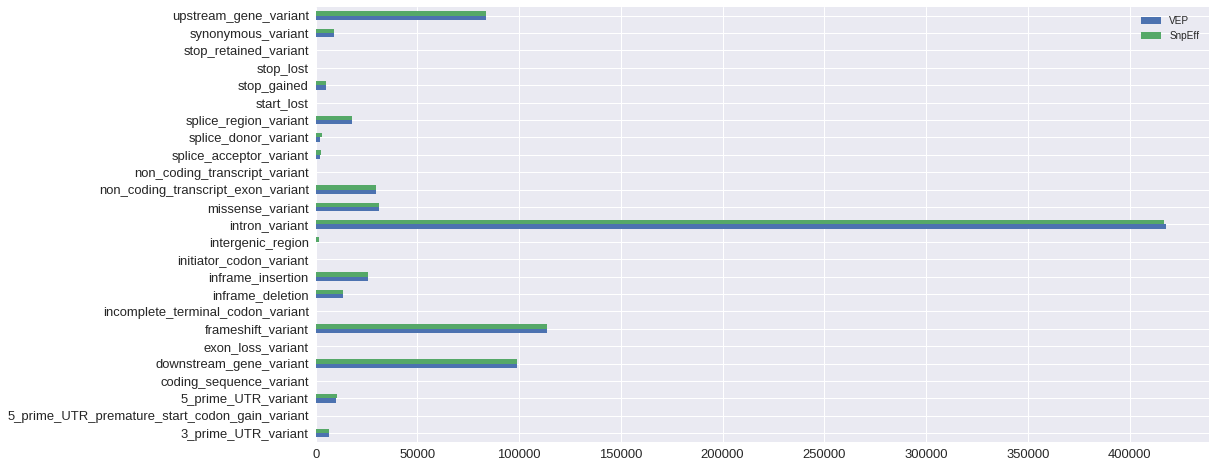

In [24]:
vc_vep = vep_df.groupby(['Normalized_effect']).size()
vc_vep.name = "VEP"
vc_snpeff = snpeff_df.groupby(['Normalized_effect']).size()
vc_snpeff.name = "SnpEff"
vc_df = pd.DataFrame([vc_vep, vc_snpeff])
print("Annotations\n")
print(vc_df.transpose().fillna(0))
vc_df.transpose().plot(kind="barh", fontsize=13, figsize=(16,8))

Now we join the VEP and SnpEff dataframes together and count number of matches

In [25]:
effect_df = pd.merge(vep_df, snpeff_df, on=['POS', 'REF', 'ALT', "Feature_id" ], how='outer', suffixes=('_vep','_snpeff'))

In [26]:
effect_df['Impact_match'] = effect_df.apply(lambda row: row['Impact_vep'] == row['Impact_snpeff'], axis=1)

In [27]:
effect_df['Effect_match'] = effect_df.apply(lambda row: row['Effect_vep'] == row['Effect_snpeff'], axis=1)

In [28]:
effect_df['Normalized_Effect_match'] = effect_df.apply(lambda row: row['Normalized_effect_vep'] == row['Normalized_effect_snpeff'], axis=1)

In [29]:
round(effect_df['Impact_match'].value_counts()/effect_df['Impact_match'].size*100, 2)

True     99.29
False     0.71
Name: Impact_match, dtype: float64

We find a 99% match between calculated impacts between tools. And below we examine the 4x4 grid of categorization matches. There are a suprising number (almost 1600) of *HIGH-LOW* disagreements. These deserve to be examined.

In [30]:
effect_df.groupby(['Impact_vep', 'Impact_snpeff'])['Impact_match'].count()

Impact_vep  Impact_snpeff
HIGH        HIGH             122728
            LOW                 307
            MODERATE             64
            MODIFIER             55
LOW         HIGH               1286
            LOW               24976
            MODERATE             19
            MODIFIER            633
MODERATE    HIGH                243
            LOW                  19
            MODERATE          70377
            MODIFIER              3
MODIFIER    HIGH                 76
            LOW                2054
            MODERATE              5
            MODIFIER         645789
Name: Impact_match, dtype: int64

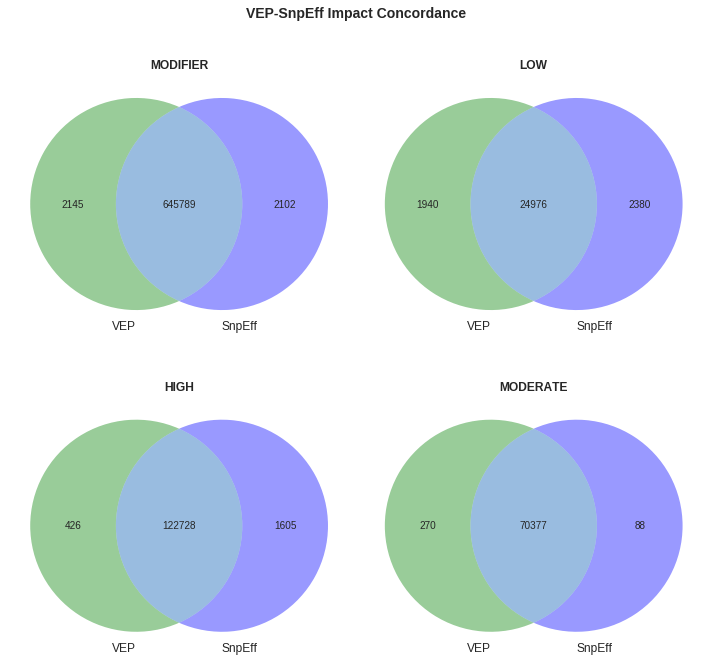

In [31]:
figure, axes = plt.subplots(2, 2)
figure.set_size_inches(10,10)
figure.suptitle("VEP-SnpEff Impact Concordance", fontsize=14, fontweight='bold')
for idx, level in enumerate(effect_df['Impact_snpeff'].dropna().unique()):
    pos = (int(idx/2), idx%2)
    vep_level = effect_df[effect_df['Impact_vep'] == level]
    snpeff_level = effect_df[effect_df['Impact_snpeff'] == level]
    axes[pos].set_title(level, fontsize=12, fontweight='bold')
    venn2_unweighted([set(vep_level.index.values), set(snpeff_level.index.values)], set_labels=('VEP', 'SnpEff'), set_colors=('g', 'b'),
                     ax=axes[pos[0]][pos[1]])
plt.tight_layout()
plt.subplots_adjust(top=.95)
plt.show()

In [32]:
round(effect_df['Effect_match'].value_counts()/effect_df['Effect_match'].size*100, 2)

True     94.57
False     5.43
Name: Effect_match, dtype: float64

Looking at the unnormalized effects, there is 95% rate of condodance.

In [33]:
pd.DataFrame(effect_df.groupby(['Effect_vep', 'Effect_snpeff'])['Effect_match'].count())

Effect_match
Effect_vep                         Effect_snpeff                                               
3_prime_UTR_variant                3_prime_UTR_variant                                     6648
                                   downstream_gene_variant                                   12
                                   frameshift_variant                                         6
                                   non_coding_transcript_variant                              6
                                   splice_region_variant                                     74
                                   stop_lost                                                  8
5_prime_UTR_variant                5_prime_UTR_premature_start_codon_gain_variant           279
                                   5_prime_UTR_variant                                     9944
                                   conservative_inframe_insertion                             1
                                   exon_loss_variant                                          3
                                   frameshift_variant                                        34
                                   non_coding_transcript_variant                             14
                                   splice_region_variant                                     34
                                   start_lost                                                15
                                   upstream_gene_variant                                     18
coding_sequence_variant            5_prime_UTR_variant                                       12
                                   frameshift_variant                                         4
                                   splice_region_variant                                     12
downstream_gene_variant            3_prime_UTR_variant                                       16
                                   downstream_gene_variant                                99161
                                   splice_region_variant                                     16
frameshift_variant                 3_prime_UTR_variant                                       14
                                   5_prime_UTR_variant                                       14
                                   exon_loss_variant                                          2
                                   frameshift_variant                                    112937
                                   splice_donor_variant                                     725
                                   splice_region_variant                                     17
incomplete_terminal_codon_variant  frameshift_variant                                         6
inframe_deletion                   conservative_inframe_deletion                           4609
                                   disruptive_inframe_deletion                             8964
                                   exon_loss_variant                                          2
                                   frameshift_variant                                        31
inframe_insertion                  3_prime_UTR_variant                                        2
                                   5_prime_UTR_variant                                        1
                                   conservative_inframe_insertion                          8624
                                   disruptive_inframe_insertion                           10130
                                   frameshift_variant                                        14
                                   splice_donor_variant                                     166
                                   splice_region_variant                                     19
intron_variant                     intron_variant                                        416576
                                   splice_region_va

In [34]:
round(effect_df['Normalized_Effect_match'].value_counts()/effect_df['Normalized_Effect_match'].size*100, 2)

True     99.08
False     0.92
Name: Normalized_Effect_match, dtype: float64

And once normalized (ie inframe annotations are generalized). The condordance rate jumps to 99%.

In [35]:
pd.DataFrame(effect_df.groupby(['Normalized_effect_vep', 'Normalized_effect_snpeff'])['Effect_match'].count())

Effect_match
Normalized_effect_vep              Normalized_effect_snpeff                                    
3_prime_UTR_variant                3_prime_UTR_variant                                     6648
                                   downstream_gene_variant                                   12
                                   frameshift_variant                                         6
                                   non_coding_transcript_variant                              6
                                   splice_region_variant                                     74
                                   stop_lost                                                  8
5_prime_UTR_variant                5_prime_UTR_premature_start_codon_gain_variant           279
                                   5_prime_UTR_variant                                     9944
                                   exon_loss_variant                                          3
                                   frameshift_variant                                        34
                                   inframe_insertion                                          1
                                   non_coding_transcript_variant                             14
                                   splice_region_variant                                     34
                                   start_lost                                                15
                                   upstream_gene_variant                                     18
coding_sequence_variant            5_prime_UTR_variant                                       12
                                   frameshift_variant                                         4
                                   splice_region_variant                                     12
downstream_gene_variant            3_prime_UTR_variant                                       16
                                   downstream_gene_variant                                99161
                                   splice_region_variant                                     16
frameshift_variant                 3_prime_UTR_variant                                       14
                                   5_prime_UTR_variant                                       14
                                   exon_loss_variant                                          2
                                   frameshift_variant                                    112937
                                   splice_donor_variant                                     725
                                   splice_region_variant                                     17
incomplete_terminal_codon_variant  frameshift_variant                                         6
inframe_deletion                   exon_loss_variant                                          2
                                   frameshift_variant                                        31
                                   inframe_deletion                                       13573
inframe_insertion                  3_prime_UTR_variant                                        2
                                   5_prime_UTR_variant                                        1
                                   frameshift_variant                                        16
                                   inframe_insertion                                      25586
                                   splice_donor_variant                                     166
                                   splice_region_variant                                     19
intron_variant                     intron_variant                                        416576
                                   splice_region_variant                                   1342
missense_variant                   missense_variant                                       30988
non_coding_transcript_exon_variant downstream_gene_

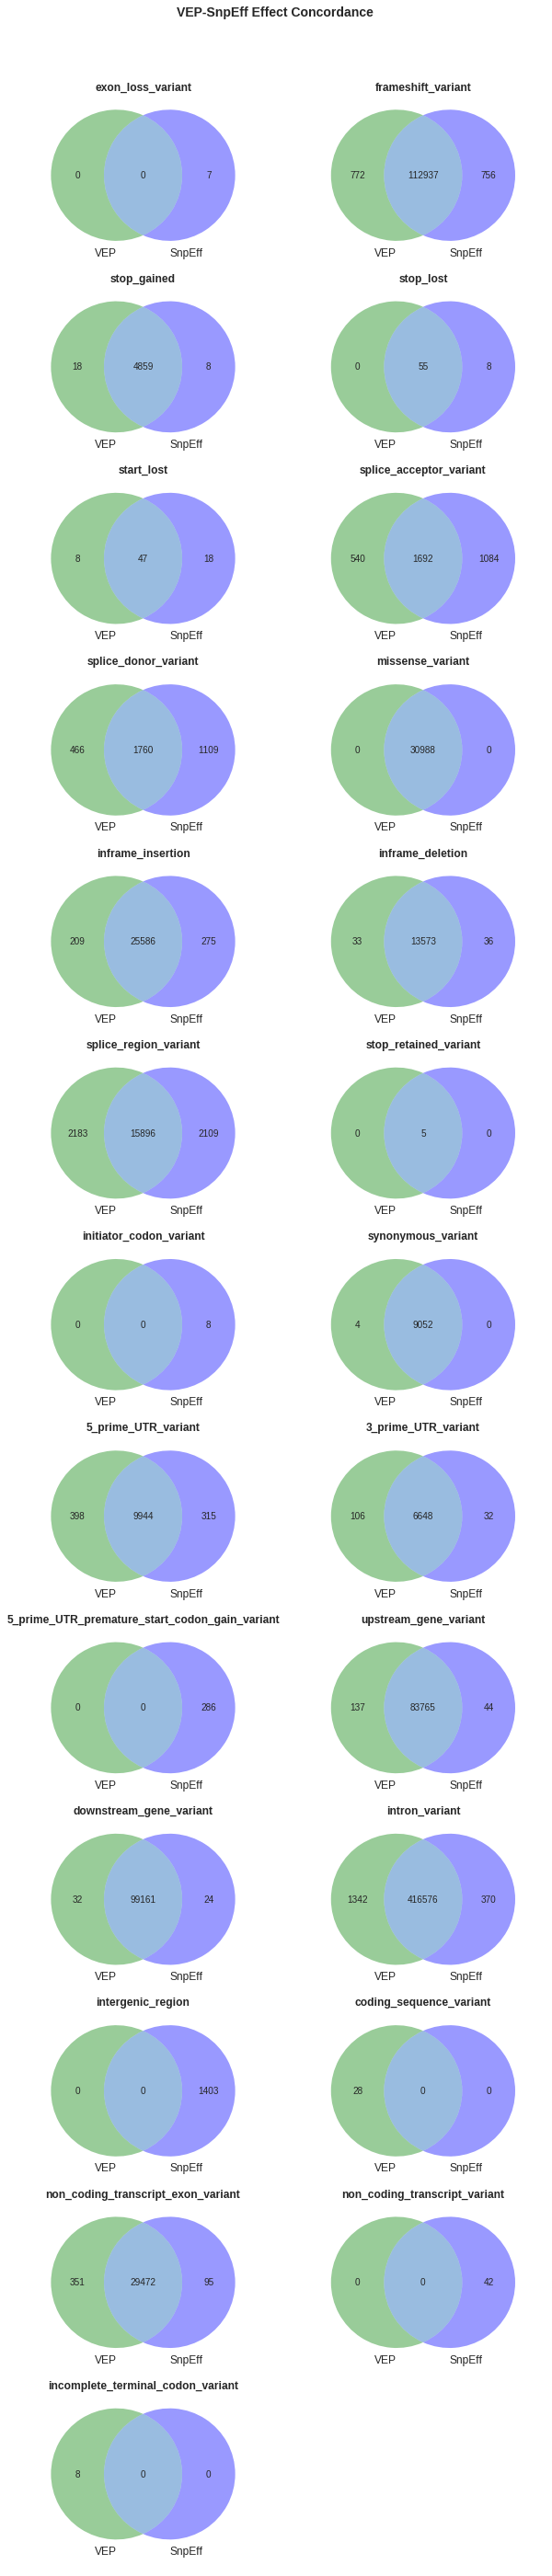

In [36]:
effect_list = sorted(set(effect_df['Normalized_effect_vep'].dropna().unique()) | set(effect_df['Normalized_effect_snpeff'].dropna().unique()), 
key=term_rank)

figure, axes = plt.subplots(13, 2)
figure.set_size_inches(10,45)
figure.suptitle("VEP-SnpEff Effect Concordance", fontsize=14, fontweight='bold')

for idx, effect in enumerate(effect_list):
    pos = (int(idx/2), idx%2)
    vep_effect = effect_df[effect_df['Normalized_effect_vep'] == effect]
    snpeff_effect = effect_df[effect_df['Normalized_effect_snpeff'] == effect]
    axes[pos].set_title(effect, fontsize=12, fontweight='bold')
    venn2_unweighted([set(vep_effect.index.values), set(snpeff_effect.index.values)], set_labels=('VEP', 'SnpEff'), set_colors=('g', 'b'),
                     ax=axes[pos[0]][pos[1]])
axes[12, 1].axis('off')

plt.subplots_adjust(top=.95)
plt.show()

# HGVS cDot Comparison

In [37]:
effect_df['Hgvsc_vep'] = effect_df['Hgvsc_vep'].str.replace(r'^.*:', '').str.strip()
effect_df['Hgvsc_snpeff'] = effect_df['Hgvsc_snpeff'].str.replace(r'^.*:', '').str.strip()

In [38]:
effect_df['Hgvsc_match'] = effect_df.apply(lambda row: row['Hgvsc_vep'] == row['Hgvsc_snpeff'], axis=1)

First, let's just see how many HGVS cDot notations are the same.

In [39]:
round(effect_df['Hgvsc_match'].value_counts()/effect_df['Hgvsc_match'].size*100, 2)

True     69.09
False    30.91
Name: Hgvsc_match, dtype: float64

We see there is about a 69% match between generated HGVS identifiers.

This isn's really a fair comparison since the tools don't always generate coding idenfiers for variants that are intergenic. So we'll check the concordance of variants where both tools generated a cDot.

In [40]:
has_hgvsc = (effect_df['Hgvsc_vep'] != '') & (effect_df['Hgvsc_snpeff'] != '')

In [41]:
filtered = effect_df[has_hgvsc]
round(filtered['Hgvsc_match'].value_counts()/filtered['Hgvsc_match'].size*100, 2)

True     87.53
False    12.47
Name: Hgvsc_match, dtype: float64

Now we see an almost 88% condordance between identifiers.

But, let's filter down to coding transcripts since these are the transcripts that contain an open reading frame

In [42]:
is_coding = (effect_df['Biotype_vep'] == 'protein_coding') & (effect_df['Biotype_snpeff'] == 'protein_coding')

In [43]:
filtered_2 = effect_df[has_hgvsc & is_coding]

In [44]:
round(filtered_2['Hgvsc_match'].value_counts()/filtered_2['Hgvsc_match'].size*100, 2)

True     86.33
False    13.67
Name: Hgvsc_match, dtype: float64

Here the condordance drops slighty to 86%.

Now let's just look at HGVS notation on the canonical transcript ENST00000003084

In [51]:
on_canonical = (effect_df['Feature_id'] == "ENST00000003084")

filtered_3 = effect_df[has_hgvsc & on_canonical]

round(filtered_3['Hgvsc_match'].value_counts()/filtered_3['Hgvsc_match'].size*100, 2)

True    100.0
Name: Hgvsc_match, dtype: float64

Wow! So on the canonical transcript, all the HGVS annotations match. Since this transcript is well chariacterized it suggests that the mismatches are being driven by differences in transcription representation (and/or parsing of the GFF file).

Let's just look at a few random mismatches

In [45]:
mismatch_df = filtered_2[filtered_2['Hgvsc_match'] == False]
mismatch_df[['POS', 'REF', 'ALT', 'Feature_id', 'Hgvsc_vep', 'Hgvsc_snpeff', 'Effect_vep', 'Effect_snpeff']]

,POS,REF,ALT,Feature_id,Hgvsc_vep,Hgvsc_snpeff,Effect_vep,Effect_snpeff
39739,117119455,TTTG,T,ENST00000446805,c.-423-58_-424+57delTTG,c.-424+57_-423-58delTTG,intron_variant,intron_variant
39779,117119456,T,TTG,ENST00000446805,c.-423-58_-424+58dupTG,c.-424+58_-423-58dupTG,intron_variant,intron_variant
39804,117119456,TTG,T,ENST00000446805,c.-423-58_-424+58delTG,c.-424+58_-423-58delTG,intron_variant,intron_variant
39829,117119457,T,TA,ENST00000446805,c.-423-58_-424+58insA,c.-424+58_-423-58insA,intron_variant,intron_variant
39839,117119457,T,TC,ENST00000446805,c.-423-58_-424+58insC,c.-424+58_-423-58insC,intron_variant,intron_variant
39854,117119457,T,TTA,ENST00000446805,c.-423-58_-424+58insTA,c.-424+58_-423-58insTA,intron_variant,intron_variant
39859,117119457,T,TTGA,ENST00000446805,c.-423-58_-424+58insTGA,c.-424+58_-423-58insTGA,intron_variant,intron_variant
39864,117119457,T,TCGA,ENST00000446805,c.-423-58_-424+58insCGA,c.-424+58_-423-58insCGA,intron_variant,intron_variant
39924,117119458,G,GTG,ENST00000446805,c.-423-58_-424+58dupTG,c.-424+58_-423-58dupTG,intron_variant,intron_variant
148045,117171029,GCT,G,ENST00000446805,c.108_109delCT,c.110_*1delCT,frameshift_variant,frameshift_variant


In [46]:
round(mismatch_df['Effect_match'].value_counts()/mismatch_df['Effect_match'].size*100, 2)

True     95.58
False     4.42
Name: Effect_match, dtype: float64

So we see a slightly higher percentage of effect mismatched among the variants that have differing cDot notations.

In [47]:
vc_vep = mismatch_df.groupby(['Effect_vep']).size()
vc_vep.name = "VEP"
vc_snpeff = mismatch_df.groupby(['Effect_snpeff']).size()
vc_snpeff.name = "SnpEff"
vc_df = pd.DataFrame([vc_vep, vc_snpeff])
print("Annotations\n")
print(vc_df.transpose().fillna(0))

Annotations

                                    VEP   SnpEff
3_prime_UTR_variant               619.0    616.0
5_prime_UTR_variant                 0.0     27.0
coding_sequence_variant            12.0      0.0
conservative_inframe_deletion       0.0    361.0
conservative_inframe_insertion      0.0    645.0
disruptive_inframe_deletion         0.0    639.0
disruptive_inframe_insertion        0.0   1282.0
exon_loss_variant                   0.0      4.0
frameshift_variant               8348.0   8323.0
inframe_deletion                 1000.0      0.0
inframe_insertion                1403.0      0.0
intron_variant                  56723.0  56668.0
missense_variant                 2288.0   2288.0
protein_altering_variant          519.0      0.0
splice_acceptor_variant           115.0    141.0
splice_donor_variant              115.0    145.0
splice_region_variant             878.0    878.0
stop_gained                       312.0    311.0
stop_lost                          25.0     29.0
stop_re

Finally, we see that the vast majority of Hgvs mismatches occur for intronic variants.

In [48]:
def create_vcf_header():
    metadata_lines = [
        '##fileformat=VCFv4.0',
        '##INFO=<ID=TX,Number=1,Type=String,Description="Corresponding Transcript"',
        '##INFO=<ID=VE,Number=1,Type=String,Description="VEP Effect"',
        '##INFO=<ID=VI,Number=1,Type=String,Description="Vep Impact"',
        '##INFO=<ID=VC,Number=1,Type=String,Description="Vep coding HGVS"',
        '##INFO=<ID=SE,Number=1,Type=String,Description="SnpEff Effect"',
        '##INFO=<ID=SI,Number=1,Type=String,Description="SnpEff Impact"',
        '##INFO=<ID=SC,Number=1,Type=String,Description="SnpEff coding HGVS"']
    header_fields = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT']
    metadata_lines.append('\t'.join(header_fields))
    vcf_header = '\n'.join(metadata_lines)
    return vcf_header

def create_vcf_line(row):
    line = []
    line.append('7')
    line.append(row['POS'])
    line.append('.')
    line.extend(row[['REF', 'ALT']])
    line.append('.')
    line.append('PASS')
    info = 'TX={};VE={};VI={};VC={};SE={};SI={};SC={}'.format(*row[['Feature_id', 'Effect_vep', 'Impact_vep', 'Hgvsc_vep',
                                                                    'Effect_snpeff', 'Impact_snpeff', 'Hgvsc_snpeff']])
    line.append(info)
    line.append('TX:VE:VI:VC:SE:SI:SC')
    return '\t'.join(map(str, line))

def create_vcf(df, idxs, filename):
    with open(filename, "w") as vcf_out:
        vcf_out.write(create_vcf_header() + '\n')
        for i in idxs:
            vcf_out.write(create_vcf_line(df.ix[i]) + '\n')

In [49]:
hgvs_mismatch = (effect_df['Hgvsc_vep'] != '') & (effect_df['Hgvsc_snpeff'] != effect_df['Hgvsc_vep'])
hgvs_mismatch_idxs = effect_df[hgvs_mismatch].sort_values(by=['POS']).index.tolist()

impact_mismatch_idxs = effect_df[~effect_df['Impact_match']].sort_values(by=['POS']).index.tolist()
effect_mismatch_idxs = effect_df[~effect_df['Effect_match']].sort_values(by=['POS']).index.tolist()

In [50]:
create_vcf(effect_df, effect_mismatch_idxs, 'effect_mismatch.vcf')
create_vcf(effect_df, impact_mismatch_idxs, 'impact_mismatch.vcf')
create_vcf(effect_df, hgvs_mismatch_idxs, 'hgvs_mismatch.vcf')